In [2]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import pytesseract as tess
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
image_folder = "./data/imgs/"
label_folder = "./data/labels/"
sample_size = 5000 # Original dataset has 25K images

## Data processing

In [4]:
def get_image_filenames():
    image_filenames = []
    for file in os.listdir(image_folder):
        image_filenames.append(file)
        
    return image_filenames

def get_label_filenames():
    label_filenames = []
    for file in os.listdir(label_folder):
        label_filenames.append(file)
        
    return label_filenames

In [5]:
all_image_filenames = get_image_filenames()
all_label_filenames = get_label_filenames()

In [6]:
labels_removed = []
imgs_removed = []

# Remove images that don't have labels, if any
for img in all_image_filenames:
    if img[:-4] + ".txt" not in all_label_filenames:
        imgs_removed.append(img)
        
# Remove labels that don't have images, if any
for lbl in all_label_filenames:
    if lbl[:-4] + ".jpg" not in all_image_filenames:
        labels_removed.append(lbl)

# Skip images that have more than one bounding box
for lbl in all_label_filenames:
    with open(label_folder + lbl, "r") as file:
        if len(file.readlines()) > 1:
            labels_removed.append(lbl)
            imgs_removed.append(lbl[:-4] + ".jpg")

# Remove images and labels that don't have a bounding box
for lbl in all_label_filenames:
    with open(label_folder + lbl, "r") as file:
        if len(file.readlines()) == 0:
            labels_removed.append(lbl)
            imgs_removed.append(lbl[:-4] + ".jpg")
            
# Remove images and labels
all_image_filenames = [img for img in all_image_filenames if img not in imgs_removed]
all_label_filenames = [lbl for lbl in all_label_filenames if lbl not in labels_removed]

# Print number of entries
print(f"{len(get_label_filenames()) - len(all_image_filenames)} of {len(get_image_filenames())} images removed.", )
print(f"{len(get_label_filenames()) - len(all_label_filenames)} of {len(get_label_filenames())} labels removed.")


0 of 5000 images removed.
0 of 5000 labels removed.


In [7]:
# Keep only a random sample of the data
np.random.seed(42)
image_filenames = np.random.choice(all_image_filenames, sample_size, replace=False)
label_filenames = [f[:-4] + ".txt" for f in image_filenames]

# Test if all image filanames have a corresponding label filename
assert all([f[:-4] + ".txt" in label_filenames for f in image_filenames])

print("Number of images:", len(image_filenames))
print("Number of labels:", len(label_filenames))


Number of images: 5000
Number of labels: 5000


In [8]:
# Copy and rename images and labels to a new folder
def copy_rename_files(image_filenames, label_filenames):
    new_image_folder = "./data/imgs/"
    new_label_folder = "./data/labels/"

    if not os.path.exists(new_image_folder):
        os.makedirs(new_image_folder)

    if not os.path.exists(new_label_folder):
        os.makedirs(new_label_folder)

    for i in range(len(image_filenames)):
        shutil.copy(image_folder + image_filenames[i], new_image_folder + f"img_{i}.jpg")
        shutil.copy(label_folder + label_filenames[i], new_label_folder + f"img_{i}.txt")

In [9]:
# Read the data
yolo_labels_dict = dict(image=[], x_center=[], y_center=[], width=[], height=[])

# Read the YOLO annotation files, and store the data in a dictionary
for file in label_filenames:
    label_file = os.path.join(label_folder, file)
    with open(label_file, "r") as lf:
        for line in lf.readlines():
            parts = line.strip().split(" ")
            class_id = int(parts[0])
            if class_id != 0:
                print("Class ID is not 0: class=", class_id)

            yolo_labels_dict["image"].append(file[:-4])
            yolo_labels_dict["x_center"].append(float(parts[1]))
            yolo_labels_dict["y_center"].append(float(parts[2]))
            yolo_labels_dict["width"].append(float(parts[3]))
            yolo_labels_dict["height"].append(float(parts[4]))

# Convert the data to a pandas dataframe
df = pd.DataFrame(yolo_labels_dict)
df.head()

,image,x_center,y_center,width,height
0,img_1244,0.734960,0.513020,0.123438,0.047917
1,img_3020,0.546875,0.516827,0.216346,0.109375
2,img_29,0.089844,0.648750,0.181667,0.219375
3,img_1564,0.513221,0.463942,0.096154,0.044471
4,img_1417,0.562500,0.561298,0.209135,0.227163


In [10]:
def yolo_to_voc(x_center, y_center, width, height, img_w, img_h):

    x_min = int((x_center - width / 2) * img_w)
    y_min = int((y_center - height / 2) * img_h)
    x_max = int((x_center + width / 2) * img_w)
    y_max = int((y_center + height / 2) * img_h)

    return x_min, y_min, x_max, y_max

In [11]:
def plot_image_with_bounding_box(img_number, x_center, y_center, width, height):
    img = cv2.imread(f"./data/imgs/{img_number}.jpg")

    # Open CV uses (x, y) coordinates of the top-left corner and the bottom-right corner
    x_min, y_min, x_max, y_max = yolo_to_voc(x_center, y_center, width, height, img.shape[1], img.shape[0])
    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

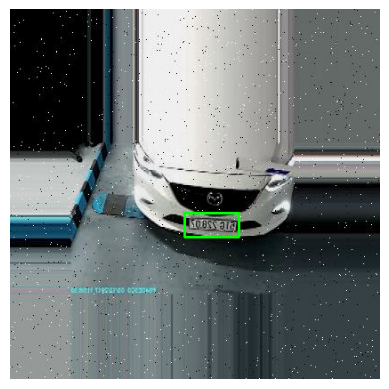

In [12]:
# Plot sample image with bounding boxes
def samplePlot():
    row = df.sample(n=1)
    plot_image_with_bounding_box(row["image"].values[0], row["x_center"].values[0], row["y_center"].values[0], row["width"].values[0], row["height"].values[0])

samplePlot()

## Data processing

In [13]:
# Convert images to array with VOC format labels
data = []
output = []

for i in range(len(df)):
    image, x_center, y_center, width, height = df.iloc[i]
    img_path = f"{image_folder}{image}.jpg"
    
    # Preprocess the image
    img_array = img_to_array(load_img(img_path, target_size=(224, 224)))
    img_array = img_array / 255.0

    data.append(img_array)
    output.append((x_center, y_center, width, height))

In [15]:
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Save the data to a file
np.savez_compressed("data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Training


In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

head_model = inception_resnet.output
head_model = Flatten()(head_model)
head_model = Dense(500,activation="relu")(head_model)
head_model = Dense(250,activation="relu")(head_model)
head_model = Dense(4,activation='sigmoid')(head_model)

model = Model(inputs=inception_resnet.input, outputs=head_model)

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=16)
model.save("object_detection.h5")